# CEAD ML project on the Ringenprinter. 
#### Welcome to the Notebook in which I will explore and visualize the data of the collected data.  

#### Material: PET-G 30% Glass Fiber
#### Dataset: PETG30GF  grote set!, 02-11-2022




## Wat zijn de korte termijn doelen te bereiken met de DATA ? 

- voorspellende functie: geef een random data punt, wat is de bead-breedte?
- voorspellende functie : geef een set van 2 RPMs, hoe ziet het verloop daar tussen uit? 

## TO DO's
- puntenwolk trimmen en recht lijn fitten
- correctie voor slijtende plaat doen

### Have Done's
- puntenwolk trimmen en recht lijn fitten

## Imports and Settings

In [1]:
# imports
# system related
import sys
import subprocess

# basics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import itertools
from datetime import datetime, time

# ml related
import sklearn as sk
# (not yet needed) 
# import torch
# import torch.nn as nn

# import scripts and functions
from functions import *

print('imports succesfull')

imports succesfull


In [2]:
# settings of pandas, usefull for data exploration
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
# if reset is required:
# pd.reset_option('all')

# increasing standard image size
matplotlib.rcParams['figure.figsize'] = (14, 7)

## Import and Preprocessing data

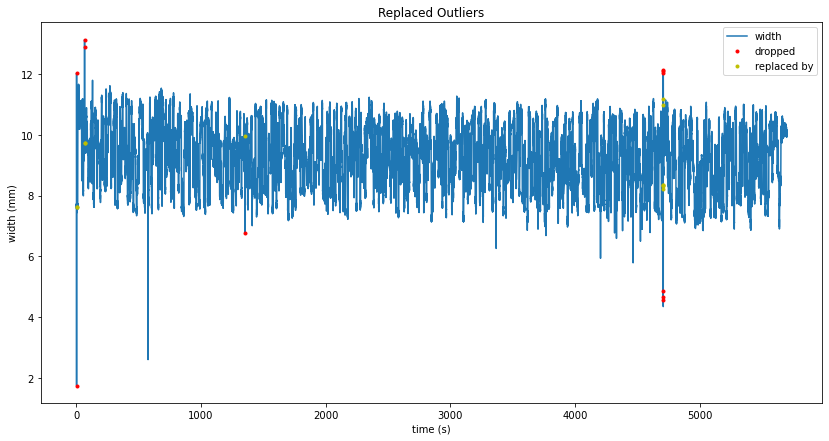

outliers detected and replaced
data median filtered
index reset
index reset


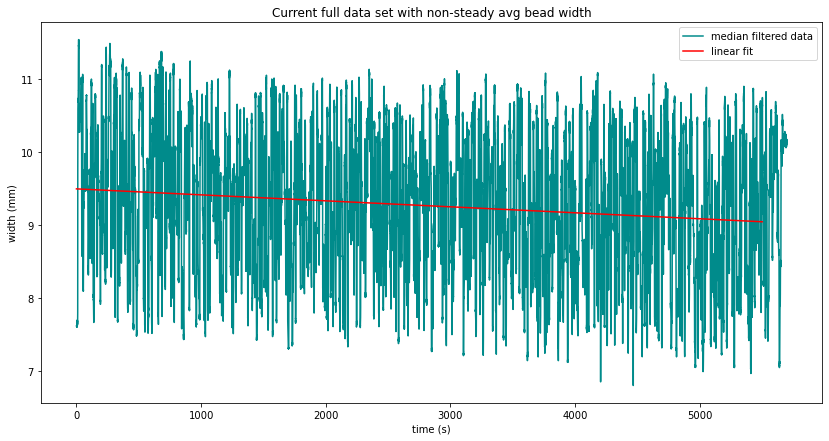

linear change over time in avg. width corrected
a, b = [3.38242572e-19], [9.4984127]


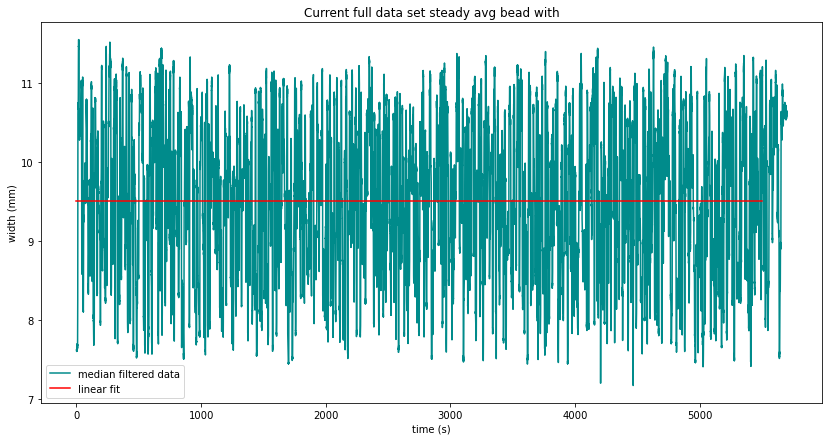

outliers detected and replaced
index reset
index reset
linear change over time in avg. width corrected

import and preprocessing data succesfull


In [3]:
# Defining import variables, _s stands for small
loc_s = '../data/petg30gs-2022-11-02.csv'
start_s = 1667393458.05
end_s = 1667399157.2

# import, filter, outlier replacement and median filtering on bead_width (mm)
df_s = import_csv_filt(loc_s, start_s, end_s, plot_outliers=True, plot_correction=True, outlier_window = 8)

df_s_no_filt = import_csv_filt(loc_s, start_s, end_s, median_filt=False, outlier_window = 8)

print('\nimport and preprocessing data succesfull')

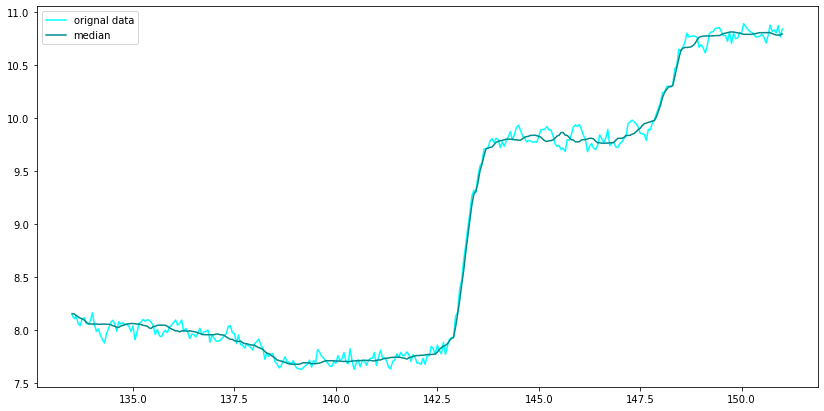

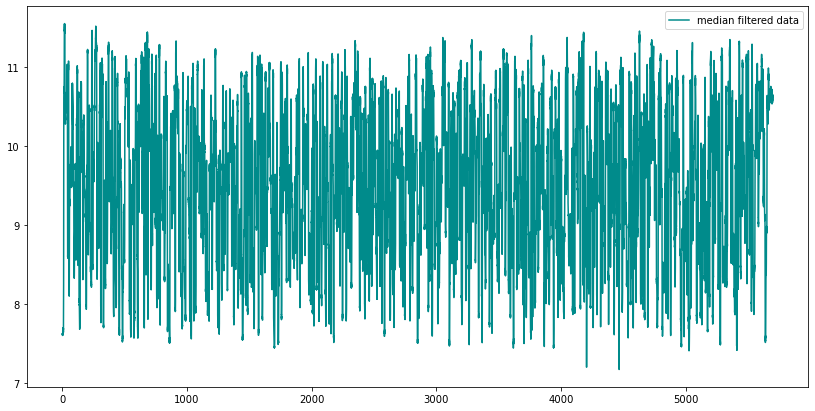

In [4]:
filter_length = 20
head_tails = int(filter_length/2)

bead_gauss = df_s['width'].rolling(window=filter_length, win_type='gaussian', center=True).mean(std=5)
bead_median = df_s['width'].rolling(window=filter_length, center=True).median()


plt.plot(df_s_no_filt.loc[2650:3000, 'time'], df_s_no_filt.loc[2650:3000, 'width'], 'cyan', label='orignal data')
plt.plot(df_s.loc[2650:3000, 'time'], df_s.loc[2650:3000, 'width'], 'darkcyan', label='median')
plt.legend()
plt.show()

plt.plot(df_s.loc[:, 'time'], df_s.loc[:, 'width'], 'darkcyan', label='median filtered data')
plt.legend()
plt.show()


## Exploration

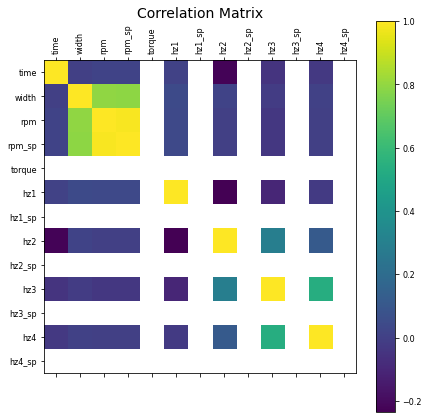

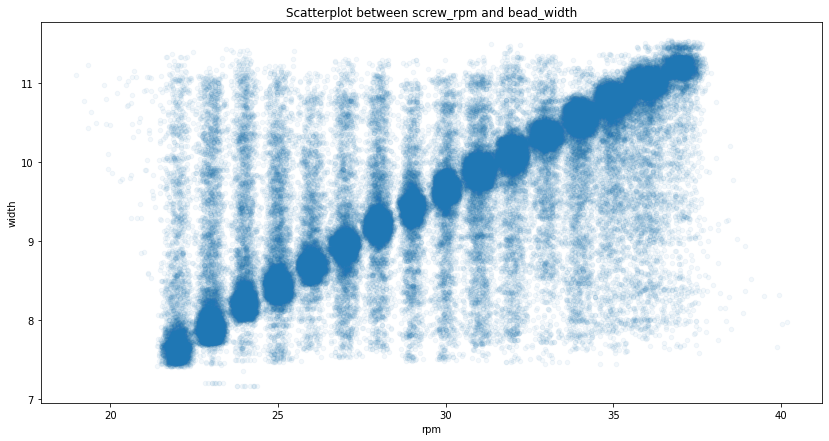

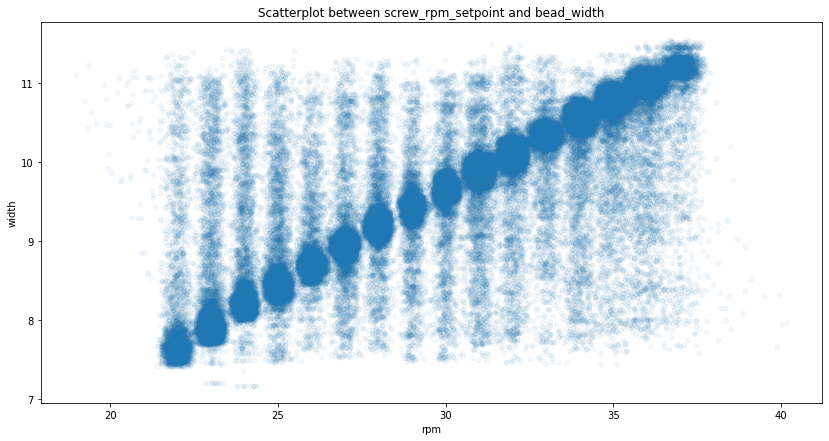

<Figure size 432x360 with 0 Axes>

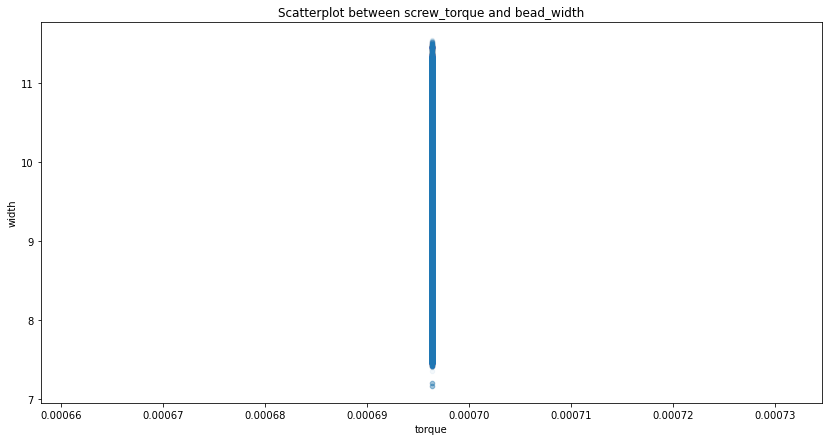

In [5]:
# plots

plt.matshow(df_s.corr())
plt.xticks(range(df_s.select_dtypes(['number']).shape[1]), df_s.select_dtypes(['number']).columns, fontsize=8, rotation=90)
plt.yticks(range(df_s.select_dtypes(['number']).shape[1]), df_s.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

df_s.plot.scatter(x='rpm', y='width', alpha = 0.05)
plt.title('Scatterplot between screw_rpm and bead_width')
plt.show()

df_s.plot.scatter(x='rpm', y='width', alpha = 0.05)
plt.title('Scatterplot between screw_rpm_setpoint and bead_width')
plt.show()


f = plt.figure(figsize=(6, 5))
df_s.plot.scatter(x='torque', y='width', alpha = 0.05)
plt.title('Scatterplot between screw_torque and bead_width')
plt.show()


## Filtering on used features only and adding history to selected features

In [6]:
# filtering dataset so only used columns are present
columns_to_keep = ['width', 'rpm']

df_s_lean = df_s[columns_to_keep]

# add history of some columns
to_expand_columns = ['rpm']
df_s_lean = df_add_column_history(df_s_lean, to_expand_columns, n_columns=0, steps=2)

## Preparing data for ML use

In [7]:
# splitting features from supervisory data
X, y = split_to_np_feat_and_ans(df_s_lean)

# scale data and normalise data

# splitting the Train and Test data
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

## Exploring ML models

#### Linear Regression

a, b =  0.235013496884546 2.571692778918326


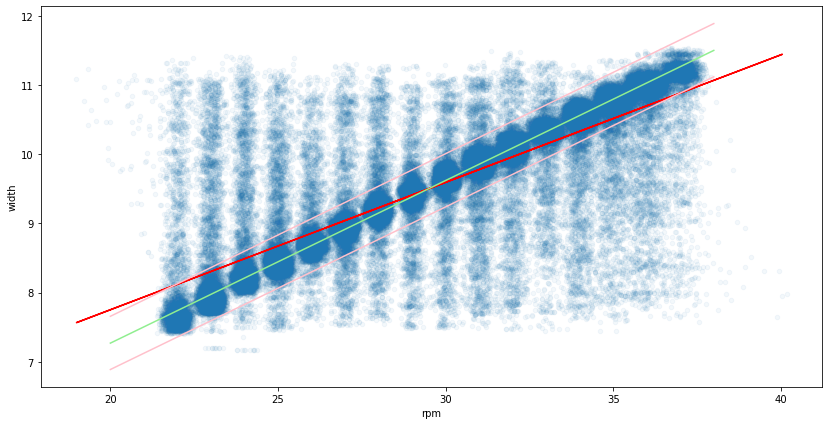

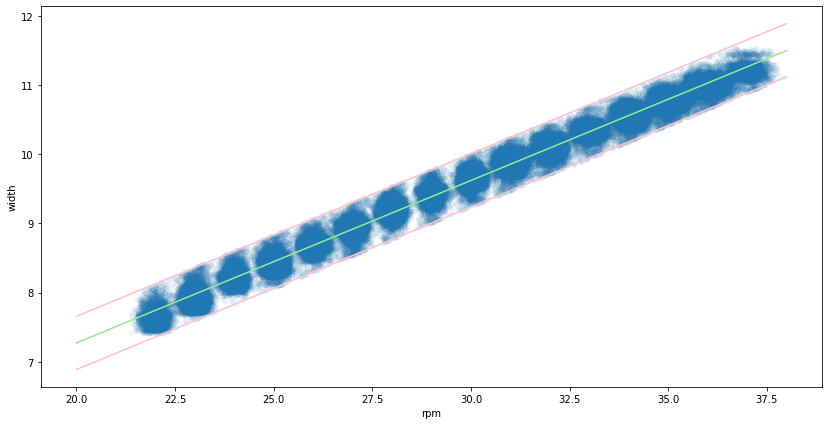

In [8]:
# imports
from sklearn.linear_model import LinearRegression

# create model
clf_lin = LinearRegression() 

# train model
clf_lin.fit(X_train, y_train)


# predict on test set
y_pred = clf_lin.predict(X_test)


# plot result
df_s_lean.plot.scatter(x='rpm', y='width', alpha = 0.05)
plt.plot(X_test, y_pred, 'r')

a = 0.235311
b = 2.56176

b_down = 2.18
b_up = 2.95


x_man = np.array([20, 38])
y_man      = x_man * a + b
y_man_down = x_man * a + b_down
y_man_up   = x_man * a + b_up

plt.plot(x_man, y_man     , 'lightgreen')
plt.plot(x_man, y_man_down, 'pink')
plt.plot(x_man, y_man_up  , 'pink')

df_trim = df_s_lean[(df_s_lean['width'] < a*df_s_lean['rpm'] + b_up) & 
                    (df_s_lean['width'] > a*df_s_lean['rpm'] + b_down)]


Xt, yt = split_to_np_feat_and_ans(df_trim)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=test_size, random_state=42)
clf_lint = LinearRegression() 
clf_lint.fit(Xt_train, yt_train)
# yt_pred = clf_lin.predict(Xt_test)

a, b = clf_lint.coef_[0], clf_lint.intercept_
print('a, b = ', clf_lint.coef_[0], clf_lint.intercept_)

df_trim.plot.scatter(x='rpm', y='width', alpha = 0.05)
plt.plot(x_man, x_man*a + b  , 'lightgreen')
plt.plot(x_man, y_man_down, 'pink')
plt.plot(x_man, y_man_up  , 'pink')

plt.show()

# give_prediction_score(y_test, y_pred)


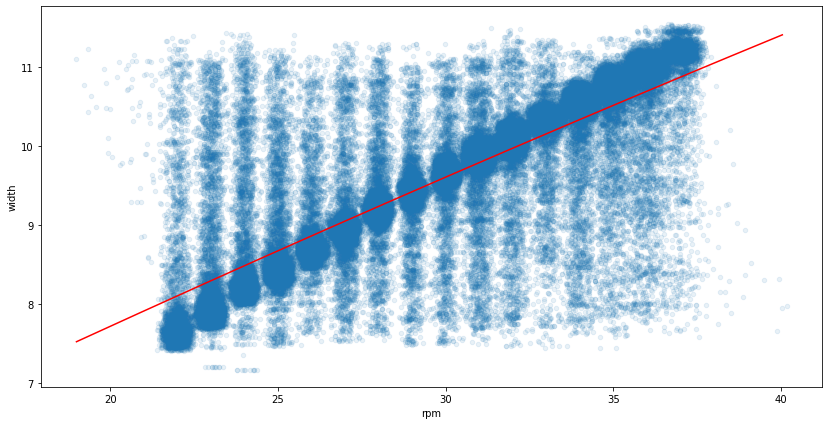

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_model=make_pipeline(PolynomialFeatures(2),LinearRegression())

# predict on test set 
poly_model.fit(X, y)
y_pred = poly_model.predict(X_test)

ind = (np.argsort(X_test, 0))
X_test = X_test[ind].reshape(-1,1)
y_pred = y_pred[ind]

# plot result
df_s_lean.plot.scatter(x='rpm', y='width', alpha = 0.1)
plt.plot(X_test, y_pred, 'r', markersize=1)
# plt.xlim(29.75, 30.25)
# plt.ylim(9.3, 9.4)
plt.show()


# give_prediction_score(y_test, y_pred)

#### True outcome vs. the expected outcome of the linear model 

coefficients: 
 0.235013496884546
intercept: 
 2.571692778918326


vals 8190 and 8300: 
7.902269881349417
9.550722342157846


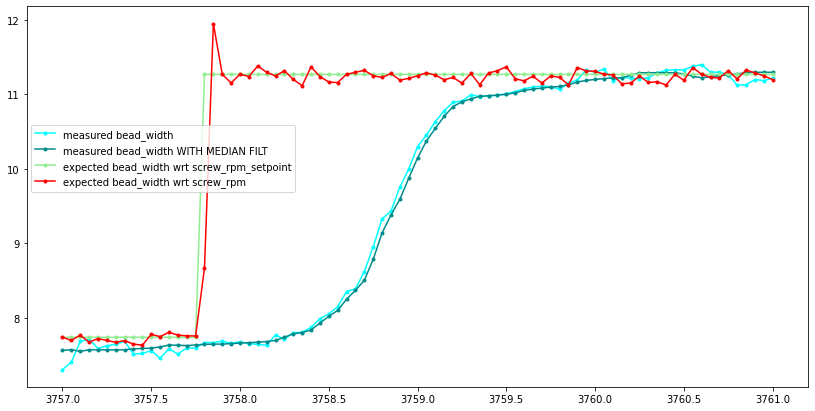

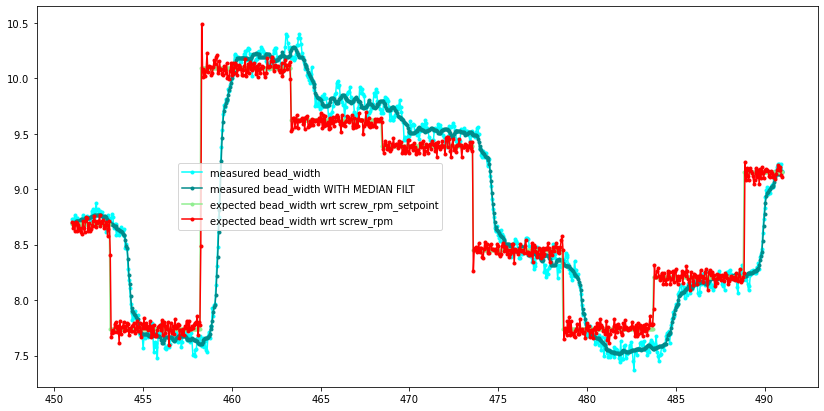

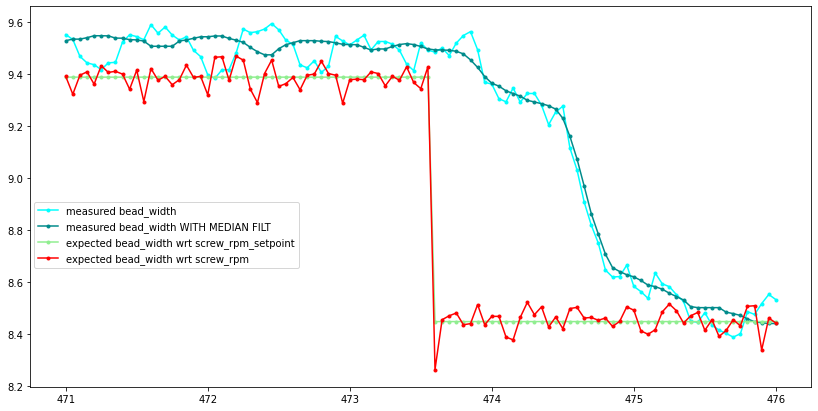

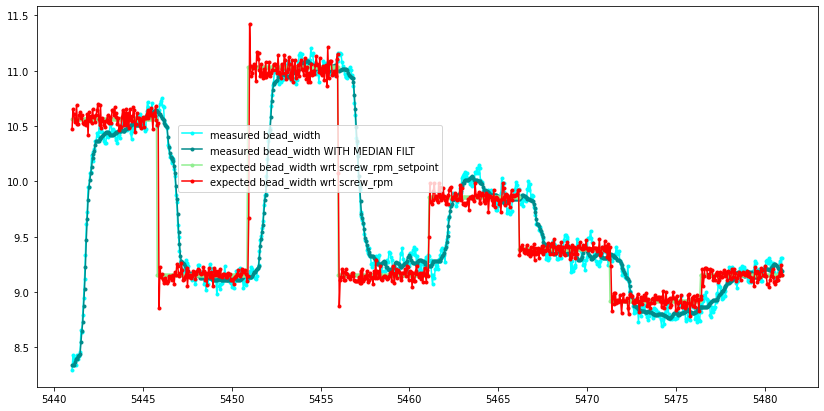

In [10]:
# # fit parameters
# a = clf_lin.coef_[0]
# b = clf_lin.intercept_


# a = 0.23
# b=  2.5


# print
print("coefficients: \n", a)
print("intercept: \n", b)

# making database with expected output/bead width
df_eo = df_s.copy(deep=True)
df_eo['exp_width'] = df_eo['rpm'] * a + b
df_eo['exp_width_sp'] = df_eo['rpm_sp'] * a + b

# making copy of original df and aligning index
df_s_copy = df_s.copy(deep=True)
# df_s_copy.drop(df_s_copy.head(head_tails).index.union(df_s_copy.tail(head_tails).index), inplace=True)
# df_s_copy = df_s_copy.reset_index()

print('\n\nvals 8190 and 8300: ')
print(df_eo.loc[8190, 'width'])
print(df_eo.loc[8300, 'width'])

# plotting
start =  3756 * 20
stop  =  3760 * 20

start_stop_pairs = [[3756 * 20, 3760 * 20], 
                    [450 * 20, 490 * 20], 
                    [470 * 20, 475 * 20], 
                    [5440 * 20, 5480 * 20]
                   ]

for ss_pair in start_stop_pairs:
    start, stop = ss_pair
    plt.plot(df_s_no_filt.loc[start:stop, 'time'], df_s_no_filt.loc[start:stop, 'width'], 'cyan', marker = '.', label='measured bead_width')
    plt.plot(df_eo.loc[start:stop, 'time'], df_eo.loc[start:stop, 'width'], 'darkcyan', marker = '.', label='measured bead_width WITH MEDIAN FILT')
    plt.plot(df_eo.loc[start:stop, 'time'], df_eo.loc[start:stop, 'exp_width_sp'], 'lightgreen', marker = '.', label='expected bead_width wrt screw_rpm_setpoint')
    plt.plot(df_eo.loc[start:stop, 'time'], df_eo.loc[start:stop, 'exp_width'], 'red', marker = '.', label='expected bead_width wrt screw_rpm')

    plt.legend( bbox_to_anchor=(0.35, 0.5), fancybox=True)
    plt.show()




## Leuke ideeen en inzichten

- het gemiste volume aan plastic als gevolg van de lag in de extrusie. Evt. te koppelen aan de jerk settings. 
- jerk/snelheid 
- als de schroef rpm wordt gekoppeld aan een maximale jerk setting, en dus langzaam wordt afgeschaald ipv stepfunties maakt, volgt het extrusie volume dan meer het gewenste profiel? 
- een flexbot oplossing zou er anders uit kunnen zien dan een extruder only oplossing!  
- ik kom van van een snelheid en ik moet de bocht om met een bepaalde snelheid, hoe ziet dat verloop functie eruit? Kan de snelheid vd robot dit volgen? past dat binnen de jerk/acc limieten? 
- 

- Gemiddelde delay? per stap? per begin? 
- per rpm change de grafiekjes normalizeren, overleggen en middelen
- kleuren per stap grootte -> conclusies






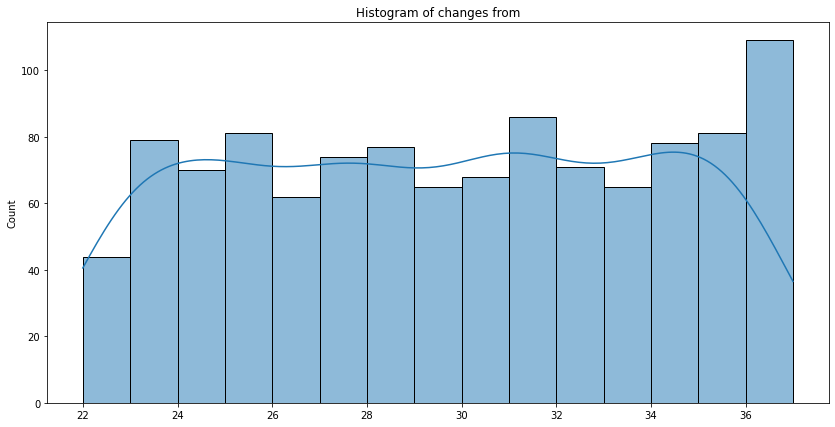

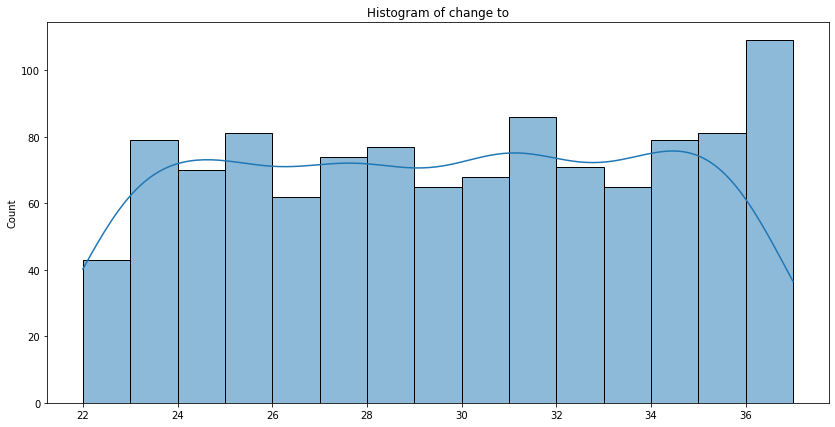

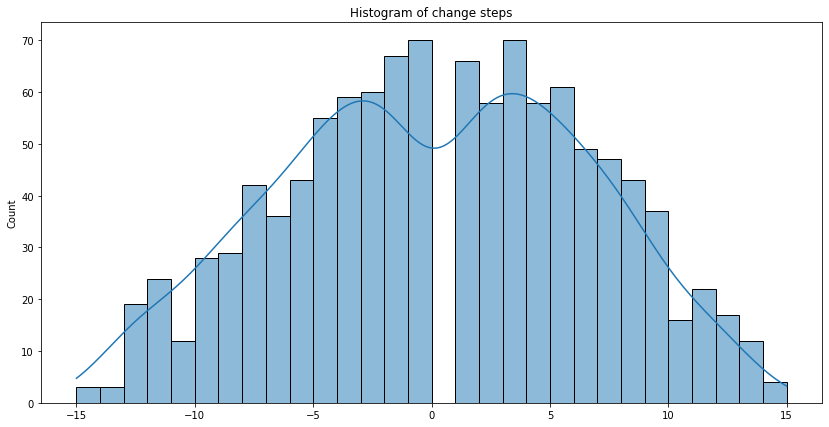

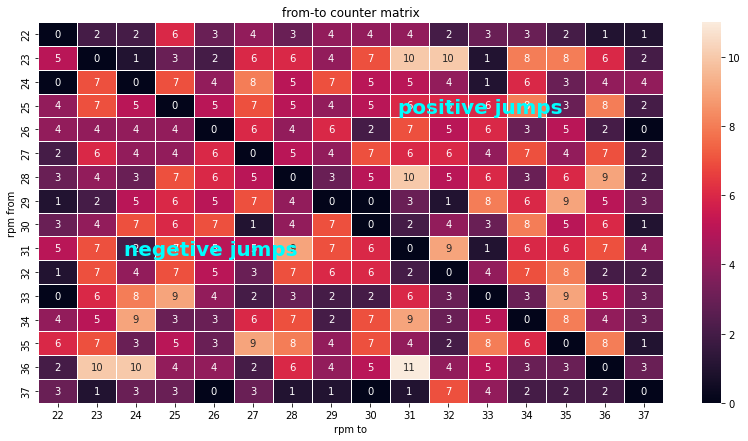

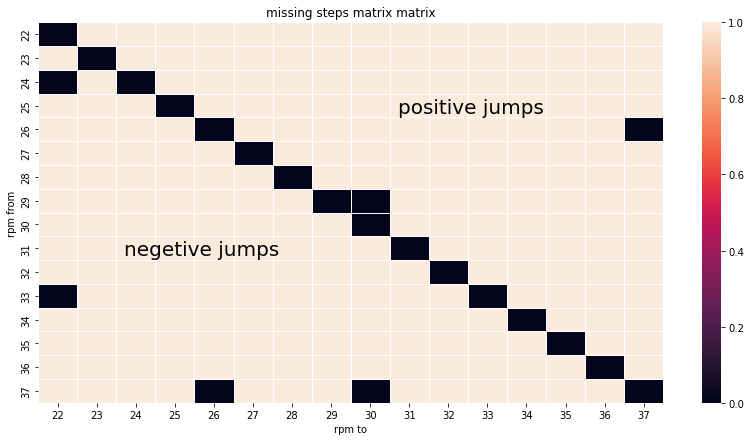

In [11]:
# ilustrationg the steps made

df_np = np.array(df_eo)
# shape = (113895, 15)
# print(df_np[0,:])

# print(df_eo)

df_np_cols = ['time', 'width', 'rpm', 'rpm_sp', 'torque',              # 0 to 4
              'hz1', 'hz1_sp', 'hz2', 'hz2_sp', 'hz3',                 # 5 to 9
              'hz3_sp', 'hz4', 'hz4_sp', 'exp_width', 'exp_width_sp']  # 10 to 14

# getting the right rpm data from the dataset
chng_idx  = df_np[:-1, 3] != df_np[1:, 3]
chng_from = df_np[:-1,3][chng_idx]
chng_to   = df_np[1:,3][chng_idx]
chng_step = chng_to - chng_from

# histograms of the from/to/step rpms
sns.histplot(chng_from, binwidth=1, kde=True)
plt.title('Histogram of changes from')
plt.show()
# ---
sns.histplot(chng_to, binwidth=1, kde=True)
plt.title('Histogram of change to')
plt.show()
# ---
sns.histplot(chng_step, binwidth=1, kde=True)
plt.title('Histogram of change steps')
plt.show()

# making the from/to heatmap
min_rpm = min(chng_to)
max_rpm = max(chng_to)

matrix_size = int(max_rpm - min_rpm + 1)
from_to_matrix = np.zeros((matrix_size, matrix_size))
missing_matrix = np.zeros((matrix_size, matrix_size))

# using nice ticks in the heatmap
ticks = np.linspace(min_rpm, max_rpm, matrix_size)
ticks = ticks.astype('int')
size_ticks = np.linspace(0, matrix_size-1, matrix_size)+.5

for i, j in zip(chng_from, chng_to):
    from_to_matrix[int(i - min_rpm), int(j-min_rpm)] += 1
    missing_matrix[int(i - min_rpm), int(j-min_rpm)] = 1

# plotting the heatmap, annotated the number of occurences inside
ax = sns.heatmap(from_to_matrix, linewidth=0.5, annot=True)
plt.title('from-to counter matrix')
plt.ylabel('rpm from')
plt.xlabel('rpm to')
plt.text(2.2, 9.8, 'negetive jumps' , fontsize=20, color='cyan', weight='bold')
plt.text(9.2, 3.8, 'positive jumps' , fontsize=20, color='cyan', weight='bold')
plt.xticks(size_ticks, ticks)
plt.yticks(size_ticks, ticks)
plt.show()

# clearly showing the missing jumps. 
ax = sns.heatmap(missing_matrix, linewidth=0.5)
plt.title('missing steps matrix matrix')
plt.ylabel('rpm from')
plt.xlabel('rpm to')
plt.text(2.2, 9.8, 'negetive jumps' , fontsize=20)
plt.text(9.2, 3.8, 'positive jumps' , fontsize=20)
plt.xticks(size_ticks, ticks)
plt.yticks(size_ticks, ticks)
plt.show()


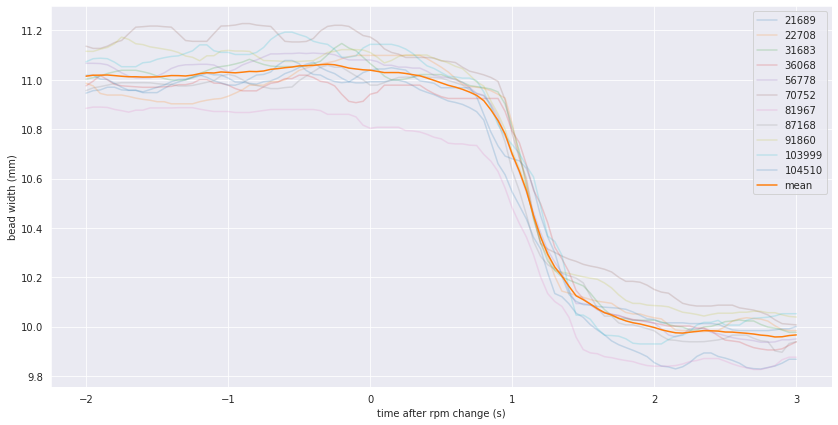

[]

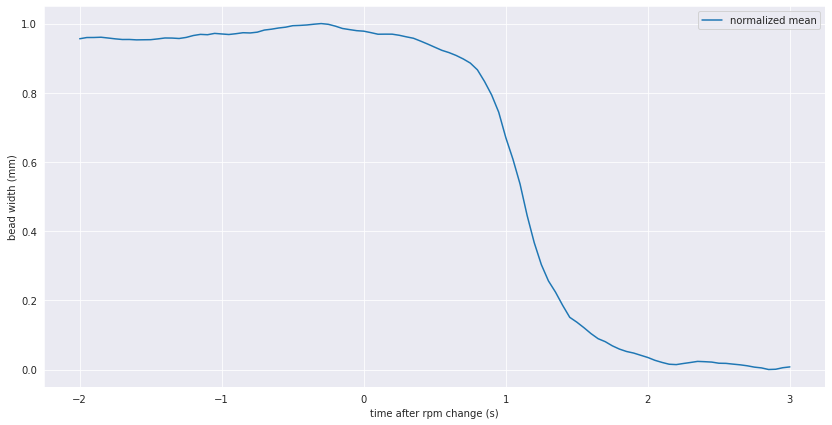

In [12]:
# point of concept for one from/to combination

# test: 36 to 31

sns.set_style("darkgrid")

idx_test_idx = chng_idx == True
idx_test_frm = df_np[:-1,3] == 36
idx_test_to  = df_np[1:,3] == 31

idx_test = np.where((idx_test_idx * idx_test_frm * idx_test_to) == True)[0]

# defining window
res = 20
seconds_before = 2
seconds_after = 3
points_b = seconds_before * res
points_a = seconds_after * res
x = np.linspace(-seconds_before, seconds_after, points_a + points_b+1)
y = np.zeros((len(idx_test),points_a + points_b +1))
idx_lst = []

for i, idx in enumerate(idx_test):
    start = idx - points_b
    stop = idx + points_a
    y[i, :] = np.array(df_eo.loc[start:stop, 'width'])
    plt.plot(x, y[i, :], label=f'{idx}', alpha = 0.2)
    idx_lst.append(idx)
    
idx_list = np.array(idx_lst).astype('int')
som = np.sum(y, axis=0)
mean = som/11

# plotting 
plt.plot(x, mean, label = 'mean')
plt.xlabel('time after rpm change (s)')
plt.ylabel('bead width (mm)')
plt.legend()
plt.show()

# plotting normalized mean
minioem = np.min(mean)
maxioem = np.max(mean)

mean_norm = (mean - np.min(mean)) / (maxioem - minioem)

plt.plot(x, mean_norm, label = 'normalized mean')
plt.xlabel('time after rpm change (s)')
plt.ylabel('bead width (mm)')
plt.legend()
plt.plot()




In [72]:
# for all kinds of jumps. 

# defining window
res = 20  # resolution of the datapoints, do not change unless data retrieving method is changed too. 
seconds_before = 1
seconds_after = 3
points_b = seconds_before * res
points_a = seconds_after * res
x = np.linspace(-seconds_before, seconds_after, points_a + points_b+1)

# change width df to numpy array for speed
width = np.array(df_eo['width'])
rpm_sp = np.array(df_eo['rpm_sp'])

# getting the right idx numbers of the dataset
chng_idx_numbers = np.where(chng_idx == True)[0]

from_to_columns = np.concatenate((chng_from.reshape(-1,1), chng_to.reshape(-1,1)), axis = 1)
final_sort_idx = np.lexsort((from_to_columns[:,1], from_to_columns[:,0]))
from_to_columns_sorted = from_to_columns[final_sort_idx]

# print(final_sort_idx[:30])
# print(from_to_columns_sorted[0:10,:])
# print(from_to_columns_sorted[1100:1110,:])

bin_edges = np.where(from_to_columns_sorted[1:, 1] != from_to_columns_sorted[:-1, 1])[0] + 1  # where jump group changes
bin_edges = np.append(np.insert(bin_edges, 0, 0), len(chng_from))  # add outer edges to series

bin_edges_ds = chng_idx_numbers[final_sort_idx[bin_edges[:-1]]]  #  <--- Where all the bin edges are in the dataset (!)
# print(rpm_sp[bin_edges_ds])
# print(from_to_columns[final_sort_idx][:10])

# print('bin_edges are:\n', bin_edges)

# print('\n\n\n\n------------------ look underneath pls ----------------\nedge sorted (1:from, 2:to) idx for the original dataset!\n\n')

final_sort_ds_from = chng_idx_numbers[final_sort_idx]      # The idx numbers in which the dataset has the last rpm before change
final_sort_ds_to   = chng_idx_numbers[final_sort_idx] + 1  # The idx numbers in whicht the dataset has the first rpm after change 

# print(rpm_sp[final_sort_ds_from][:30])  #            <--- works for rpm FROM !
# print(rpm_sp[final_sort_ds_to][:30])#            <--- works for rpm TO !

x = np.linspace(-seconds_before, seconds_after, points_a + points_b+1)



sorted_data_dict = {}

for i, edge in enumerate(bin_edges):
    if i == 0:
        edge_prev = edge
        continue
    
    n_jumps = edge - edge_prev
    y= np.zeros((n_jumps, points_a + points_b +1))
    
    for j, k in enumerate(range(edge_prev, edge)):
        ds_idx = chng_idx_numbers[final_sort_idx[k]]
        start = ds_idx - points_b
        stop = ds_idx + points_a
        y[j,:] = width[start:stop+1]
        # plt.plot(x, y[j,:], label=f'{j}', alpha = 0.2)
        
    mean = np.sum(y, axis=0)/n_jumps
    
    # minioem = np.min(mean)  #             <-- for normalisation between 0 and 1
    # maxioem = np.max(mean)
    
    minioem, maxioem = np.quantile(mean, [0.20, 0.80])
    
    mean_norm = (mean - minioem) / (maxioem - minioem) 
    sorted_data_dict[(rpm_sp[ds_idx], rpm_sp[ds_idx+1])] = mean_norm
    edge_prev = edge


Using matplotlib backend: QtAgg


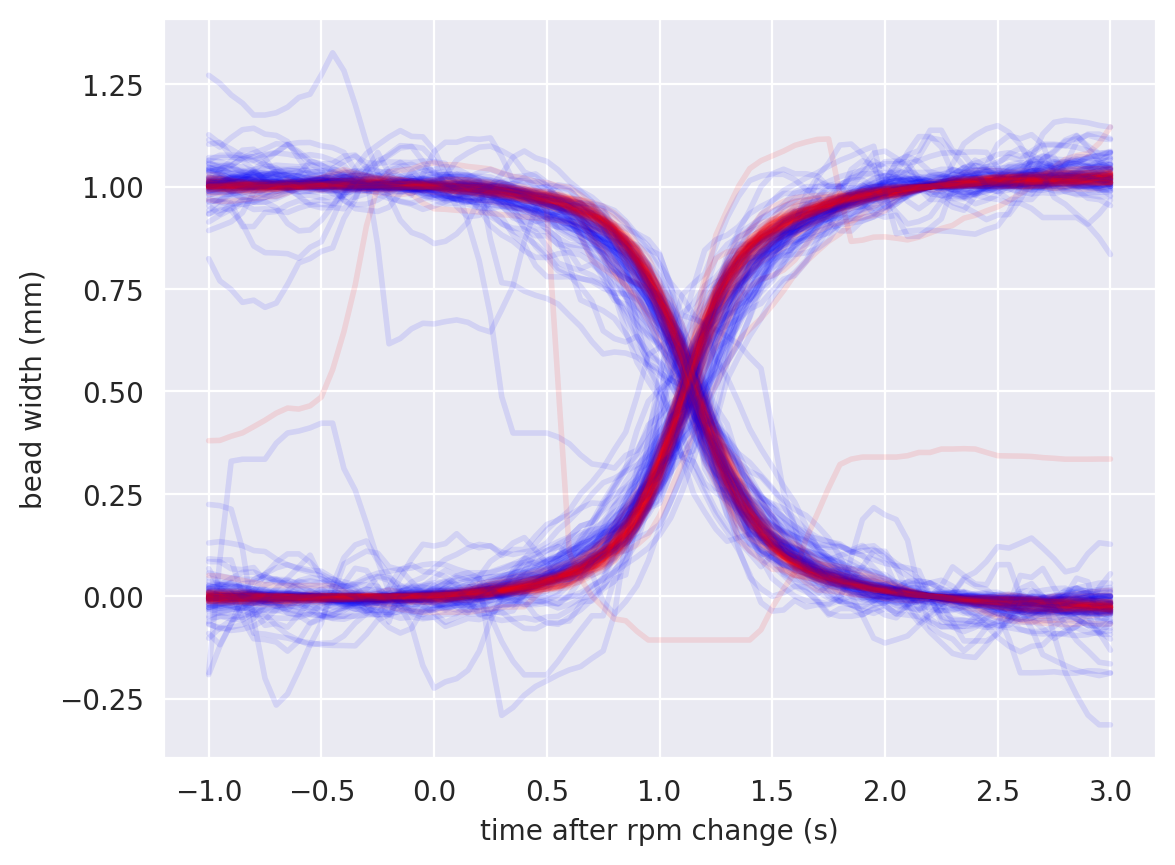

In [87]:
%matplotlib

fig, ax = plt.subplots()

items = list(sorted_data_dict.items())
np.random.shuffle(items)
    
for key, line in items:
    b, a = key
    ax.plot(x, line, label = f'rpms {b}' +r' $\rightarrow$ ' + f'{a}', alpha = 0.1,
    c = cm.bwr((abs(a - b)-5.5)*22), linewidth = 2) 
    
    # ((a or b)-10)/33


ax.set_xlabel('time after rpm change (s)')
ax.set_ylabel('bead width (mm)')


plt.ion()

In [85]:
ax.plot([-1,3],[0.5,0.5])